<a href="https://colab.research.google.com/github/gkrisp98/Animal-classification-Kaggle/blob/main/Animal_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **IMPORT DATASET FROM KAGGLE**

In [ ]:
!pip install -U kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kongkrispanis","key":"a48b5e8dac475d1264af8b66919a0275"}'}

In [ ]:
!kaggle datasets download -d pratik2901/animal-dataset

 99% 223M/225M [00:07<00:00, 34.6MB/s]
100% 225M/225M [00:08<00:00, 29.4MB/s]


In [ ]:
!unzip /content/animal-dataset.zip

# **TASK 1 - OVERFIT MOBILE NET**

IMPORTS

In [ ]:
import torch
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F

Load the dataset

In [ ]:
# Define the transform for loading the images
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

# Load the dataset
dataset = datasets.ImageFolder('/content/animal_dataset_intermediate/train', transform = None)

In [ ]:
import torch
from torch.utils.data import Dataset, TensorDataset, random_split
from torchvision import transforms
class MyDataset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
        
    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y
        
    def __len__(self):
        return len(self.subset)

    
init_dataset = dataset

lengths = [int(len(init_dataset)*0.8+1), int(len(init_dataset)*0.2)]
train, test = torch.utils.data.random_split(init_dataset, lengths)
train_dataset = MyDataset(
    train, transform=transform
)
test_dataset = MyDataset(
    test, transform=transform
)

In [ ]:
init_dataset = train_dataset
lengths = [int(len(init_dataset)*0.9)+1, int(len(init_dataset)*0.1)]
train, val = torch.utils.data.random_split(init_dataset, lengths)
val_dataset = MyDataset(
    test, transform=transform
)

In [ ]:
import torch.nn as nn
from torchsummary import summary

def dwise_conv(ch_in, stride=1):
    return (
        nn.Sequential(
            #depthwise
            nn.Conv2d(ch_in, ch_in, kernel_size=3, padding=1, stride=stride, groups=ch_in, bias=False),
            nn.BatchNorm2d(ch_in),
            nn.ReLU6(inplace=True),
            #torch.nn.Dropout(p=0.2)
        )
    )

def conv1x1(ch_in, ch_out):
    return (
        nn.Sequential(
            nn.Conv2d(ch_in, ch_out, kernel_size=1, padding=0, stride=1, bias=False),
            nn.BatchNorm2d(ch_out),
            nn.ReLU6(inplace=True),
            #nn.Dropout(p=0.2)
        )
    )

def conv3x3(ch_in, ch_out, stride):
    return (
        nn.Sequential(
            nn.Conv2d(ch_in, ch_out, kernel_size=3, padding=1, stride=stride, bias=False),
            nn.BatchNorm2d(ch_out),
            nn.ReLU6(inplace=True),
            #torch.nn.Dropout(p=0.2)
        )
    )

class InvertedBlock(nn.Module):
    def __init__(self, ch_in, ch_out, expand_ratio, stride):
        super(InvertedBlock, self).__init__()

        self.stride = stride
        assert stride in [1,2]

        hidden_dim = ch_in * expand_ratio

        self.use_res_connect = self.stride==1 and ch_in==ch_out

        layers = []
        if expand_ratio != 1:
            layers.append(conv1x1(ch_in, hidden_dim))
        layers.extend([
            #dw
            dwise_conv(hidden_dim, stride=stride),
            #pw
            conv1x1(hidden_dim, ch_out)
        ])

        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        if self.use_res_connect:
            return x + self.layers(x)
        else:
            return self.layers(x)

class MobileNetV2(nn.Module):
    def __init__(self, ch_in=3, n_classes=1000):
        super(MobileNetV2, self).__init__()

        self.configs=[
            # t, c, n, s
            [1, 16, 1, 1],
            [6, 24, 2, 2],
            [6, 32, 3, 2],
            [6, 64, 4, 2],
            [6, 96, 3, 1],
            [6, 160, 3, 2],
            [6, 320, 1, 1]
        ]

        self.stem_conv = conv3x3(ch_in, 32, stride=2)

        layers = []
        input_channel = 32
        for t, c, n, s in self.configs:
            for i in range(n):
                stride = s if i == 0 else 1
                layers.append(InvertedBlock(ch_in=input_channel, ch_out=c, expand_ratio=t, stride=stride))
                input_channel = c

        self.layers = nn.Sequential(*layers)

        self.last_conv = conv1x1(input_channel, 1280)

        self.classifier = nn.Sequential(
            #nn.Dropout(0.2),
            nn.Linear(1280, n_classes)
        )
        self.avg_pool = nn.AdaptiveAvgPool2d(1)

    def forward(self, x):
        x = self.stem_conv(x)
        x = self.layers(x)
        x = self.last_conv(x)
        x = self.avg_pool(x).view(-1, 1280)
        x = self.classifier(x)
        return x

In [ ]:
model = MobileNetV2(ch_in=3, n_classes=5).cuda()

In [ ]:
# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=True)

In [ ]:
import torch.optim as optim

# define number of epochs
num_epochs = 40

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Lists to keep track of the training and validation losses
train_losses = []
val_losses = []

# Training loop
for epoch in range(num_epochs):
    train_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.cuda(), labels.cuda()
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_losses.append(train_loss)
    
    val_loss = 0.0
    model.eval()
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.cuda(), labels.cuda()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    val_losses.append(val_loss)
    model.train()
    
    print(f'Epoch {epoch+1}/{num_epochs} - Training Loss: {train_loss:.4f} - Validation Loss: {val_loss:.4f}')

Epoch 1/40 - Training Loss: 70.3335 - Validation Loss: 18.6956
Epoch 2/40 - Training Loss: 59.9639 - Validation Loss: 14.8908
Epoch 3/40 - Training Loss: 54.3297 - Validation Loss: 15.4578
Epoch 4/40 - Training Loss: 49.9204 - Validation Loss: 19.1252
Epoch 5/40 - Training Loss: 45.1186 - Validation Loss: 12.5308
Epoch 6/40 - Training Loss: 42.2536 - Validation Loss: 12.2627
Epoch 7/40 - Training Loss: 37.7593 - Validation Loss: 12.0670
Epoch 8/40 - Training Loss: 33.9261 - Validation Loss: 11.6783
Epoch 9/40 - Training Loss: 31.2589 - Validation Loss: 13.1915
Epoch 10/40 - Training Loss: 27.5505 - Validation Loss: 11.7888
Epoch 11/40 - Training Loss: 25.3255 - Validation Loss: 11.5984
Epoch 12/40 - Training Loss: 20.8673 - Validation Loss: 17.9026
Epoch 13/40 - Training Loss: 22.1871 - Validation Loss: 11.4865
Epoch 14/40 - Training Loss: 17.1778 - Validation Loss: 12.7316
Epoch 15/40 - Training Loss: 13.1033 - Validation Loss: 12.9534
Epoch 16/40 - Training Loss: 11.7744 - Validation

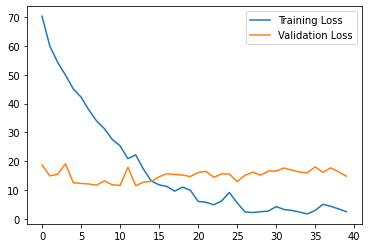

In [ ]:
import matplotlib.pyplot as plt
# Plot the training and validation loss
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.show()

# **TASKS 2-4 MOBILE NET**

In [ ]:
import torch
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F

**TRANSFORMS**

In [ ]:
# Define the transform for loading the images
train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.GaussianBlur(3),
    transforms.RandomRotation(15),
    transforms.ToTensor()
])

# Define the test transformation
test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])
# Load the dataset
dataset = datasets.ImageFolder('/content/animal_dataset_intermediate/train', transform = None)

**SPLIT DATASETS**

In [ ]:
import torch
from torch.utils.data import Dataset, TensorDataset, random_split
from torchvision import transforms
class MyDataset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
        
    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y
        
    def __len__(self):
        return len(self.subset)

    
init_dataset = dataset

lengths = [int(len(init_dataset)*0.8+1), int(len(init_dataset)*0.2)]

train, test = torch.utils.data.random_split(init_dataset, lengths)
train_dataset = MyDataset(
    train, transform=train_transform
)
test_dataset = MyDataset(
    test, transform=test_transform
)

In [ ]:
#DEYTERH XRHSH THS SYNARTHSHS GIA VALIDATION SET
init_dataset = train_dataset
lengths = [int(len(init_dataset)*0.9)+1, int(len(init_dataset)*0.1)]
train, val = torch.utils.data.random_split(init_dataset, lengths)
val_dataset = MyDataset(
    test, transform=test_transform
)

val_dataset = MyDataset(
    val, transform=test_transform
)

In [ ]:
train_dataset[343][0][0].shape

torch.Size([224, 224])

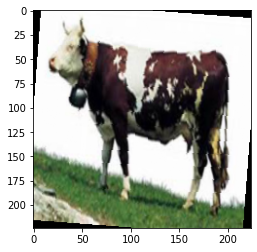

In [ ]:
import matplotlib.pyplot as plt 
image, label = train_dataset[5478]
plt.imshow(image.permute(1,2,0))
plt.show()

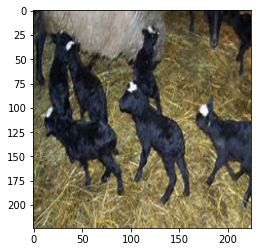

In [ ]:
import matplotlib.pyplot as plt 
image, label = dataset[5478]
plt.imshow(image.permute(1,2,0))
plt.show()

In [ ]:
print(type(dataset[0][0]))

<class 'torch.Tensor'>


**DEFINE MODEL**

In [ ]:
import torch.nn as nn
from torchsummary import summary

def dwise_conv(ch_in, stride=1):
    return (
        nn.Sequential(
            #depthwise
            nn.Conv2d(ch_in, ch_in, kernel_size=3, padding=1, stride=stride, groups=ch_in, bias=False),
            nn.BatchNorm2d(ch_in),
            nn.ReLU6(inplace=True),
            torch.nn.Dropout(p=0.2)
        )
    )

def conv1x1(ch_in, ch_out):
    return (
        nn.Sequential(
            nn.Conv2d(ch_in, ch_out, kernel_size=1, padding=0, stride=1, bias=False),
            nn.BatchNorm2d(ch_out),
            nn.ReLU6(inplace=True),
            #nn.Dropout(p=0.2)
        )
    )

def conv3x3(ch_in, ch_out, stride):
    return (
        nn.Sequential(
            nn.Conv2d(ch_in, ch_out, kernel_size=3, padding=1, stride=stride, bias=False),
            nn.BatchNorm2d(ch_out),
            nn.ReLU6(inplace=True),
            #torch.nn.Dropout(p=0.2)
        )
    )

class InvertedBlock(nn.Module):
    def __init__(self, ch_in, ch_out, expand_ratio, stride):
        super(InvertedBlock, self).__init__()

        self.stride = stride
        assert stride in [1,2]

        hidden_dim = ch_in * expand_ratio

        self.use_res_connect = self.stride==1 and ch_in==ch_out

        layers = []
        if expand_ratio != 1:
            layers.append(conv1x1(ch_in, hidden_dim))
        layers.extend([
            #dw
            dwise_conv(hidden_dim, stride=stride),
            #pw
            conv1x1(hidden_dim, ch_out)
        ])

        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        if self.use_res_connect:
            return x + self.layers(x)
        else:
            return self.layers(x)

class MobileNetV2(nn.Module):
    def __init__(self, ch_in=3, n_classes=1000):
        super(MobileNetV2, self).__init__()

        self.configs=[
            # t, c, n, s
            [1, 16, 1, 1],
            [6, 24, 2, 2],
            [6, 32, 3, 2],
            [6, 64, 4, 2],
            [6, 96, 3, 1],
            [6, 160, 3, 2],
            [6, 320, 1, 1]
        ]

        self.stem_conv = conv3x3(ch_in, 32, stride=2)

        layers = []
        input_channel = 32
        for t, c, n, s in self.configs:
            for i in range(n):
                stride = s if i == 0 else 1
                layers.append(InvertedBlock(ch_in=input_channel, ch_out=c, expand_ratio=t, stride=stride))
                input_channel = c

        self.layers = nn.Sequential(*layers)

        self.last_conv = conv1x1(input_channel, 1280)

        self.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(1280, n_classes)
        )
        self.avg_pool = nn.AdaptiveAvgPool2d(1)

    def forward(self, x):
        x = self.stem_conv(x)
        x = self.layers(x)
        x = self.last_conv(x)
        x = self.avg_pool(x).view(-1, 1280)
        x = self.classifier(x)
        return x

In [ ]:
model = MobileNetV2(ch_in=3, n_classes=5).cuda()

In [ ]:
x = torch.rand(64,3,224,224).cuda()
y = model(x)

**CREATE DATALOADERS**

In [ ]:
# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=128, shuffle=True) 
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=True)

In [ ]:
len(train_dataset)

6557

In [ ]:
len(val_dataset)

1639

**TRAINING - VALIDATION LOOP/PLOT LOSSES**

In [ ]:
import torch.optim as optim

# define number of epochs
num_epochs = 100

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)

# Lists to keep track of the training and validation losses
train_losses = []
val_losses = []

# Training loop
for epoch in range(num_epochs):
    train_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.cuda(), labels.cuda()
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_losses.append(train_loss)

    torch.save({
          'model_state_dict': model.state_dict(),
          'optimizer_state_dict': optimizer.state_dict(),
          'epoch': epoch,
          'loss':train_loss},
          '/content/drive/MyDrive/custom3.pth')
    
    val_loss = 0.0
    model.eval()
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.cuda(), labels.cuda()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    val_losses.append(val_loss)
    torch.save({'valid_loss':val_loss}, '/content/drive/MyDrive/custom3.pth')
    model.train()
    
    print(f'Epoch {epoch+1}/{num_epochs} - Training Loss: {train_loss:.4f} - Validation Loss: {val_loss:.4f}')

Epoch 1/100 - Training Loss: 79.8591 - Validation Loss: 39.7002
Epoch 2/100 - Training Loss: 74.9512 - Validation Loss: 32.6630
Epoch 3/100 - Training Loss: 72.8377 - Validation Loss: 26.4452
Epoch 4/100 - Training Loss: 71.0267 - Validation Loss: 43.4823
Epoch 5/100 - Training Loss: 68.5056 - Validation Loss: 50.2396
Epoch 6/100 - Training Loss: 68.8358 - Validation Loss: 30.8556
Epoch 7/100 - Training Loss: 66.3858 - Validation Loss: 40.6338
Epoch 8/100 - Training Loss: 65.5187 - Validation Loss: 27.0556
Epoch 9/100 - Training Loss: 64.1843 - Validation Loss: 27.0759
Epoch 10/100 - Training Loss: 62.5816 - Validation Loss: 22.6248
Epoch 11/100 - Training Loss: 62.3681 - Validation Loss: 26.1591
Epoch 12/100 - Training Loss: 60.9688 - Validation Loss: 27.8184
Epoch 13/100 - Training Loss: 61.1185 - Validation Loss: 26.8834
Epoch 14/100 - Training Loss: 59.3869 - Validation Loss: 28.0192
Epoch 15/100 - Training Loss: 59.1649 - Validation Loss: 24.6054
Epoch 16/100 - Training Loss: 58.2

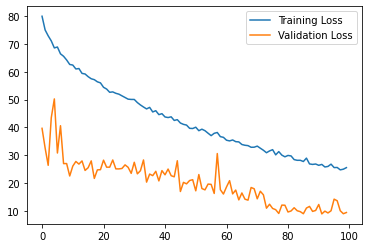

In [ ]:
import matplotlib.pyplot as plt
# Plot the training and validation loss
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.show()

**OVERALL ACCURACY**

In [ ]:
#TESTING
correct = 0
total = 0
all_preds = []
all_labels = []
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.cuda(), labels.cuda()
        all_labels.append(labels)
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        all_preds.append(predicted)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network: {100 * correct // total} %')

Accuracy of the network: 83 %


In [ ]:
model.cpu()

MobileNetV2(
  (stem_conv): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU6(inplace=True)
  )
  (layers): Sequential(
    (0): InvertedBlock(
      (layers): Sequential(
        (0): Sequential(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
          (3): Dropout(p=0.2, inplace=False)
        )
        (1): Sequential(
          (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
      )
    )
    (1): InvertedBlock(
      (layers): Sequential(
        (0): Sequential(
          (0): Conv2d(16, 96,

In [ ]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.4/512.4 KB 23.2 MB/s eta 0:00:00


**CLASSIFICATION REPORT**

In [ ]:
import torch
#from torchmetrics.functional import precision_recall
all_labels = torch.cat(all_labels)
all_preds = torch.cat(all_preds)

import sklearn
from sklearn import metrics
from sklearn.metrics import f1_score, accuracy_score
print(metrics.classification_report(all_labels.cpu(), all_preds.cpu()))
print("F1 micro: %1.4f\n" % f1_score(all_labels.cpu(), all_preds.cpu(), average='micro'))
print("F1 macro: %1.4f\n" % f1_score(all_labels.cpu(), all_preds.cpu(), average='macro'))
print("F1 weighted: %1.4f\n" % f1_score(all_labels.cpu(), all_preds.cpu(), average='weighted'))
print("Accuracy: %1.4f" % (accuracy_score(all_labels.cpu(), all_preds.cpu())))
#precision_recall(all_preds, all_labels, average='macro', num_classes=5)

              precision    recall  f1-score   support

           0       0.86      0.77      0.81       265
           1       0.89      0.97      0.93       377
           2       0.81      0.85      0.83       349
           3       0.80      0.73      0.77       324
           4       0.83      0.85      0.84       324

    accuracy                           0.84      1639
   macro avg       0.84      0.83      0.83      1639
weighted avg       0.84      0.84      0.84      1639

F1 micro: 0.8395

F1 macro: 0.8341

F1 weighted: 0.8378

Accuracy: 0.8395


**CONFUSSION MATRIX**

In [ ]:
from torchmetrics import ConfusionMatrix

confmat = ConfusionMatrix(num_classes=5, task = 'multiclass')
print("Confusion Matrix:", confmat(all_preds.cpu(), all_labels.cpu()))

Confusion Matrix: tensor([[204,   5,  22,  15,  19],
        [  2, 366,   2,   3,   4],
        [ 10,   6, 295,  27,  11],
        [ 17,  10,  39, 237,  21],
        [  4,  25,   8,  13, 274]])


In [ ]:
#class accuracies
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(all_labels.cpu(), all_preds.cpu())
matrix.diagonal()/matrix.sum(axis=1)

array([0.76981132, 0.97082228, 0.84527221, 0.73148148, 0.84567901])

**DISPLAY THE CONFUSION MATRIX**

In [ ]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
tensor([[204,   5,  22,  15,  19],
        [  2, 366,   2,   3,   4],
        [ 10,   6, 295,  27,  11],
        [ 17,  10,  39, 237,  21],
        [  4,  25,   8,  13, 274]])


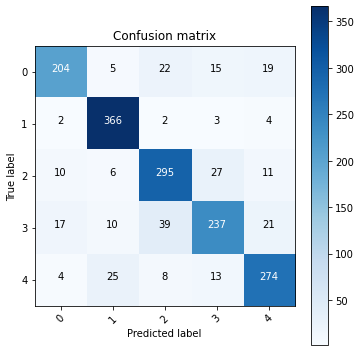

In [ ]:
cm = confmat(all_preds.cpu(), all_labels.cpu())
plt.figure(figsize=(5,5))
plot_confusion_matrix(cm, [0,1,2,3,4])

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
# Test the model
model.eval()
all_y_test = []
all_y_score = []
with torch.no_grad():
    for data, labels in test_loader:
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        all_y_test.append(labels.cpu().numpy())
        all_y_score.append(outputs.cpu().numpy())

In [ ]:
import numpy as np
y_test = np.concatenate(all_y_test)

In [ ]:
y_score = np.concatenate(all_y_score)

In [ ]:
from sklearn.preprocessing import LabelBinarizer
label_binarizer = LabelBinarizer()
label_binarizer = LabelBinarizer().fit(y_test)
y_onehot_test = label_binarizer.transform(y_test)

In [ ]:
y_onehot_test

array([[0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1],
       ...,
       [0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0]])

**ROC CURVES**

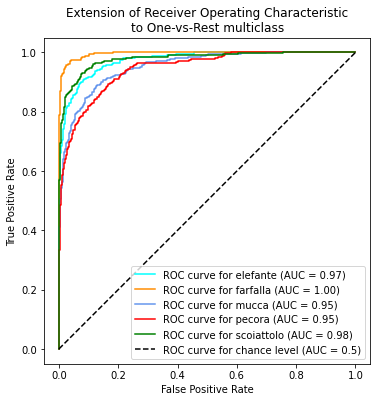

In [ ]:
from sklearn.metrics import RocCurveDisplay
from itertools import cycle

n_classes = 5
target_names = ['elefante', 'farfalla', 'mucca', 'pecora', 'scoiattolo']
fig, ax = plt.subplots(figsize=(6, 6))
colors = cycle(["aqua", "darkorange", "cornflowerblue", "r", "g", "b"])
for class_id, color in zip(range(n_classes), colors):
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        y_score[:, class_id],
        name=f"ROC curve for {target_names[class_id]}",
        color=color,
        ax=ax,
    )

plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass")
plt.legend()
plt.show()

**GLOBAL REPRESENTATIONS WITH TSNE**

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


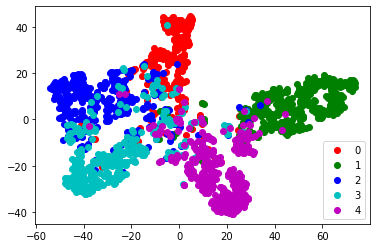

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Extract the global image representations from the last convolutional layer
all_representations = []
all_labels = []
with torch.no_grad():
    for data, labels in test_loader:
        outputs = model(data)
        representations = outputs.view(outputs.size(0), -1)
        all_representations.append(representations.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

# Flatten the list of representations and labels
all_representations = np.concatenate(all_representations)
all_labels = np.concatenate(all_labels)

# Apply t-SNE to further reduce the dimensionality and visualize the representations
tsne = TSNE(n_components=2)
tsne_representations = tsne.fit_transform(all_representations)

# Visualize the representations
colors = ['r', 'g', 'b', 'c', 'm']
for i in range(5):
    class_indices = np.where(all_labels == i)[0]
    plt.scatter(tsne_representations[class_indices, 0], tsne_representations[class_indices, 1], c=colors[i], label=i)
plt.legend()
plt.show()

**GLOBAL REPRESENTATIONS WITH PCA**

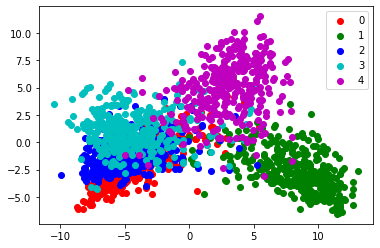

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Extract the global image representations from the last convolutional layer
all_representations = []
all_labels = []
with torch.no_grad():
    for data, labels in test_loader:
        outputs = model(data)
        representations = outputs.view(outputs.size(0), -1)
        all_representations.append(representations.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

# Flatten the list of representations and labels
all_representations = np.concatenate(all_representations)
all_labels = np.concatenate(all_labels)

# Apply PCA to reduce the dimensionality of the representations
pca = PCA(n_components=2)
pca_representations = pca.fit_transform(all_representations)

# Visualize the representations
colors = ['r', 'g', 'b', 'c', 'm']
for i in range(5):
    class_indices = np.where(all_labels == i)[0]
    plt.scatter(pca_representations[class_indices, 0], pca_representations[class_indices, 1], c=colors[i], label=i)
plt.legend()
plt.show()

# **TASK 1 - OVERFIT RESNET**

IMPORTS

In [ ]:
import torch
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F

Load the dataset

In [ ]:
# Define the transform for loading the images
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

# Load the dataset
dataset = datasets.ImageFolder('/content/animal_dataset_intermediate/train', transform = None)

In [ ]:
import torch
from torch.utils.data import Dataset, TensorDataset, random_split
from torchvision import transforms
class MyDataset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
        
    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y
        
    def __len__(self):
        return len(self.subset)

    
init_dataset = dataset

lengths = [int(len(init_dataset)*0.8+1), int(len(init_dataset)*0.2)]
train, test = torch.utils.data.random_split(init_dataset, lengths)
train_dataset = MyDataset(
    train, transform=transform
)
test_dataset = MyDataset(
    test, transform=transform
)

In [ ]:
#DEYTERH XRHSH THS SYNARTHSHS GIA VALIDATION SET
init_dataset = train_dataset
lengths = [int(len(init_dataset)*0.9)+1, int(len(init_dataset)*0.1)]
train, val = torch.utils.data.random_split(init_dataset, lengths)
val_dataset = MyDataset(
    test, transform=transform
)

In [ ]:
import torch.nn as nn
import torchvision.models as models

model = models.resnet18()

# Replace the last fully-connected layer
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 5)
model.cuda()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=True)

In [ ]:
import torch.optim as optim

# define number of epochs
num_epochs = 40

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Lists to keep track of the training and validation losses
train_losses = []
val_losses = []

# Training loop
for epoch in range(num_epochs):
    train_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.cuda(), labels.cuda()
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_losses.append(train_loss)
    
    val_loss = 0.0
    model.eval()
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.cuda(), labels.cuda()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    val_losses.append(val_loss)
    model.train()
    
    print(f'Epoch {epoch+1}/{num_epochs} - Training Loss: {train_loss:.4f} - Validation Loss: {val_loss:.4f}')

Epoch 1/40 - Training Loss: 62.0206 - Validation Loss: 22.1688
Epoch 2/40 - Training Loss: 44.7403 - Validation Loss: 14.5358
Epoch 3/40 - Training Loss: 39.0102 - Validation Loss: 14.5742
Epoch 4/40 - Training Loss: 33.5040 - Validation Loss: 11.1389
Epoch 5/40 - Training Loss: 30.2493 - Validation Loss: 22.5760
Epoch 6/40 - Training Loss: 26.5251 - Validation Loss: 13.7259
Epoch 7/40 - Training Loss: 22.1238 - Validation Loss: 11.3421
Epoch 8/40 - Training Loss: 20.5143 - Validation Loss: 22.7850
Epoch 9/40 - Training Loss: 16.8523 - Validation Loss: 12.1235
Epoch 10/40 - Training Loss: 13.6974 - Validation Loss: 10.9298
Epoch 11/40 - Training Loss: 11.3832 - Validation Loss: 47.7171
Epoch 12/40 - Training Loss: 11.5271 - Validation Loss: 12.1352
Epoch 13/40 - Training Loss: 7.0977 - Validation Loss: 10.4702
Epoch 14/40 - Training Loss: 5.2315 - Validation Loss: 14.3113
Epoch 15/40 - Training Loss: 7.3846 - Validation Loss: 12.3891
Epoch 16/40 - Training Loss: 5.7507 - Validation Los

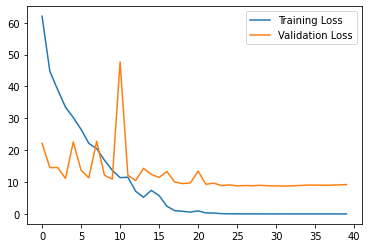

In [ ]:
import matplotlib.pyplot as plt
# Plot the training and validation loss
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.show()

# **TASKS 2-4 RES18**

In [ ]:
import torch
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
# Define the transform for loading the images
train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.GaussianBlur(3),
    transforms.RandomRotation(15),
    transforms.ToTensor()
])

# Define the test transformation
test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])
# Load the dataset
dataset = datasets.ImageFolder('/content/animal_dataset_intermediate/train', transform = None)

In [ ]:
import torch
from torch.utils.data import Dataset, TensorDataset, random_split
from torchvision import transforms
class MyDataset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
        
    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y
        
    def __len__(self):
        return len(self.subset)

    
init_dataset = dataset

lengths = [int(len(init_dataset)*0.8+1), int(len(init_dataset)*0.2)]
train, test = torch.utils.data.random_split(init_dataset, lengths)
train_dataset = MyDataset(
    train, transform=train_transform
)
test_dataset = MyDataset(
    test, transform=test_transform
)

In [ ]:
#DEYTERH XRHSH THS SYNARTHSHS GIA VALIDATION SET
init_dataset = train_dataset
lengths = [int(len(init_dataset)*0.9)+1, int(len(init_dataset)*0.1)]
train, val = torch.utils.data.random_split(init_dataset, lengths)
val_dataset = MyDataset(
    val, transform=test_transform
)

In [ ]:
train_dataset[343][0][0].shape

torch.Size([224, 224])

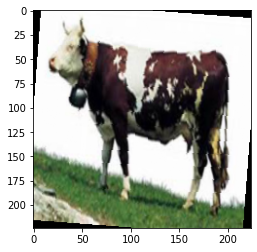

In [ ]:
import matplotlib.pyplot as plt 
image, label = train_dataset[5478]
plt.imshow(image.permute(1,2,0))
plt.show()

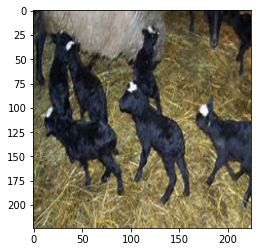

In [ ]:
import matplotlib.pyplot as plt 
image, label = dataset[5478]
plt.imshow(image.permute(1,2,0))
plt.show()

In [ ]:
print(type(dataset[0][0]))

<class 'torch.Tensor'>


In [ ]:
import torch.nn as nn
import torchvision.models as models

model = models.resnet18()

# Replace the last fully-connected layer
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 5)
model.cuda()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=128, shuffle=True) 
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=True)

In [ ]:
len(train_dataset)

6557

In [ ]:
len(val_dataset)

1639

In [ ]:
import torch.optim as optim

# define number of epochs
num_epochs = 80

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)

# Lists to keep track of the training and validation losses
train_losses = []
val_losses = []

# Training loop
for epoch in range(num_epochs):
    train_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.cuda(), labels.cuda()
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_losses.append(train_loss)

    torch.save({
          'model_state_dict': model.state_dict(),
          'optimizer_state_dict': optimizer.state_dict(),
          'epoch': epoch,
          'loss':train_loss},
          '/content/drive/MyDrive/res.pth')
    
    val_loss = 0.0
    model.eval()
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.cuda(), labels.cuda()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    val_losses.append(val_loss)
    torch.save({'valid_loss':val_loss}, '/content/drive/MyDrive/res.pth')
    model.train()
    
    print(f'Epoch {epoch+1}/{num_epochs} - Training Loss: {train_loss:.4f} - Validation Loss: {val_loss:.4f}')

Epoch 1/80 - Training Loss: 71.4398 - Validation Loss: 17.5191
Epoch 2/80 - Training Loss: 61.9987 - Validation Loss: 15.5825
Epoch 3/80 - Training Loss: 55.6989 - Validation Loss: 15.0172
Epoch 4/80 - Training Loss: 51.2178 - Validation Loss: 21.7288
Epoch 5/80 - Training Loss: 47.9907 - Validation Loss: 12.8888
Epoch 6/80 - Training Loss: 45.5368 - Validation Loss: 13.9836
Epoch 7/80 - Training Loss: 44.2233 - Validation Loss: 25.3952
Epoch 8/80 - Training Loss: 42.0213 - Validation Loss: 18.1125
Epoch 9/80 - Training Loss: 39.8481 - Validation Loss: 14.6763
Epoch 10/80 - Training Loss: 38.2169 - Validation Loss: 22.5191
Epoch 11/80 - Training Loss: 37.8061 - Validation Loss: 11.7323
Epoch 12/80 - Training Loss: 36.3806 - Validation Loss: 13.4777
Epoch 13/80 - Training Loss: 34.9228 - Validation Loss: 8.9868
Epoch 14/80 - Training Loss: 34.1035 - Validation Loss: 12.7766
Epoch 15/80 - Training Loss: 33.3961 - Validation Loss: 12.0542
Epoch 16/80 - Training Loss: 34.0894 - Validation 

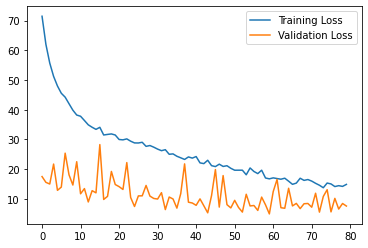

In [ ]:
import matplotlib.pyplot as plt
# Plot the training and validation loss
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.show()

In [ ]:
#TESTING
correct = 0
total = 0
all_preds = []
all_labels = []
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.cuda(), labels.cuda()
        all_labels.append(labels)
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        all_preds.append(predicted)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network: {100 * correct // total} %')

Accuracy of the network: 88 %


In [ ]:
model.cpu()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
#from torchmetrics.functional import precision_recall
all_labels = torch.cat(all_labels)
all_preds = torch.cat(all_preds)

import sklearn
from sklearn import metrics
from sklearn.metrics import f1_score, accuracy_score
print(metrics.classification_report(all_labels.cpu(), all_preds.cpu()))
print("F1 micro: %1.4f\n" % f1_score(all_labels.cpu(), all_preds.cpu(), average='micro'))
print("F1 macro: %1.4f\n" % f1_score(all_labels.cpu(), all_preds.cpu(), average='macro'))
print("F1 weighted: %1.4f\n" % f1_score(all_labels.cpu(), all_preds.cpu(), average='weighted'))
print("Accuracy: %1.4f" % (accuracy_score(all_labels.cpu(), all_preds.cpu())))
#precision_recall(all_preds, all_labels, average='macro', num_classes=5)

              precision    recall  f1-score   support

           0       0.86      0.91      0.89       258
           1       0.95      0.94      0.95       413
           2       0.84      0.86      0.85       340
           3       0.89      0.81      0.84       308
           4       0.87      0.89      0.88       320

    accuracy                           0.88      1639
   macro avg       0.88      0.88      0.88      1639
weighted avg       0.88      0.88      0.88      1639

F1 micro: 0.8841

F1 macro: 0.8805

F1 weighted: 0.8839

Accuracy: 0.8841


In [ ]:
from torchmetrics import ConfusionMatrix

confmat = ConfusionMatrix(num_classes=5, task = 'multiclass')
print("Confusion Matrix:", confmat(all_preds.cpu(), all_labels.cpu()))

Confusion Matrix: tensor([[235,   0,  12,   2,   9],
        [  1, 389,   5,   3,  15],
        [ 17,   8, 292,  17,   6],
        [ 14,   2,  32, 248,  12],
        [  6,  11,   8,  10, 285]])


In [ ]:
#class accuracies
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(all_labels.cpu(), all_preds.cpu())
matrix.diagonal()/matrix.sum(axis=1)

array([0.91085271, 0.94188862, 0.85882353, 0.80519481, 0.890625  ])

In [ ]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
tensor([[235,   0,  12,   2,   9],
        [  1, 389,   5,   3,  15],
        [ 17,   8, 292,  17,   6],
        [ 14,   2,  32, 248,  12],
        [  6,  11,   8,  10, 285]])


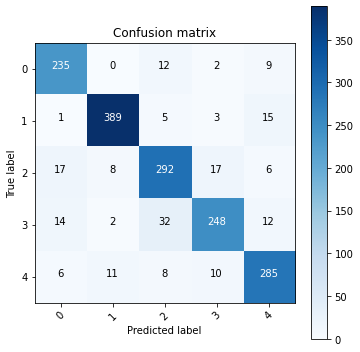

In [ ]:
cm = confmat(all_preds.cpu(), all_labels.cpu())
plt.figure(figsize=(5,5))
plot_confusion_matrix(cm, [0,1,2,3,4])

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
# Test the model
model.eval()
all_y_test = []
all_y_score = []
with torch.no_grad():
    for data, labels in test_loader:
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        all_y_test.append(labels.cpu().numpy())
        all_y_score.append(outputs.cpu().numpy())

In [ ]:
import numpy as np
y_test = np.concatenate(all_y_test)

In [ ]:
y_score = np.concatenate(all_y_score)

In [ ]:
from sklearn.preprocessing import LabelBinarizer
label_binarizer = LabelBinarizer()
label_binarizer = LabelBinarizer().fit(y_test)
y_onehot_test = label_binarizer.transform(y_test)

In [ ]:
y_onehot_test

array([[0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 1],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1]])

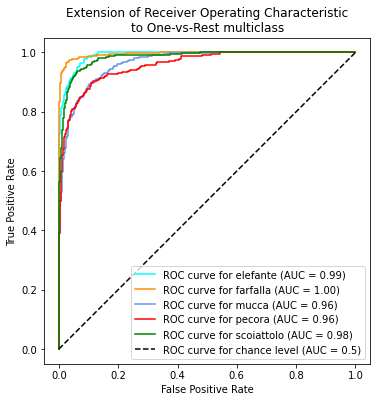

In [ ]:
from sklearn.metrics import RocCurveDisplay
from itertools import cycle

n_classes = 5
target_names = ['elefante', 'farfalla', 'mucca', 'pecora', 'scoiattolo']
fig, ax = plt.subplots(figsize=(6, 6))
colors = cycle(["aqua", "darkorange", "cornflowerblue", "r", "g", "b"])
for class_id, color in zip(range(n_classes), colors):
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        y_score[:, class_id],
        name=f"ROC curve for {target_names[class_id]}",
        color=color,
        ax=ax,
    )

plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass")
plt.legend()
plt.show()

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


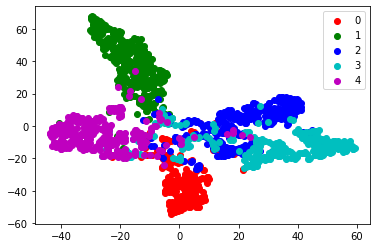

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Extract the global image representations from the last convolutional layer
all_representations = []
all_labels = []
with torch.no_grad():
    for data, labels in test_loader:
        outputs = model(data)
        representations = outputs.view(outputs.size(0), -1)
        all_representations.append(representations.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

# Flatten the list of representations and labels
all_representations = np.concatenate(all_representations)
all_labels = np.concatenate(all_labels)

# Apply t-SNE to further reduce the dimensionality and visualize the representations
tsne = TSNE(n_components=2)
tsne_representations = tsne.fit_transform(all_representations)

# Visualize the representations
colors = ['r', 'g', 'b', 'c', 'm']
for i in range(5):
    class_indices = np.where(all_labels == i)[0]
    plt.scatter(tsne_representations[class_indices, 0], tsne_representations[class_indices, 1], c=colors[i], label=i)
plt.legend()
plt.show()

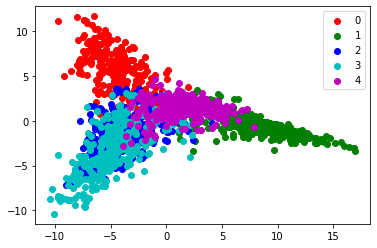

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Extract the global image representations from the last convolutional layer
all_representations = []
all_labels = []
with torch.no_grad():
    for data, labels in test_loader:
        outputs = model(data)
        representations = outputs.view(outputs.size(0), -1)
        all_representations.append(representations.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

# Flatten the list of representations and labels
all_representations = np.concatenate(all_representations)
all_labels = np.concatenate(all_labels)

# Apply PCA to reduce the dimensionality of the representations
pca = PCA(n_components=2)
pca_representations = pca.fit_transform(all_representations)

# Visualize the representations
colors = ['r', 'g', 'b', 'c', 'm']
for i in range(5):
    class_indices = np.where(all_labels == i)[0]
    plt.scatter(pca_representations[class_indices, 0], pca_representations[class_indices, 1], c=colors[i], label=i)
plt.legend()
plt.show()